100%|██████████| 170M/170M [00:42<00:00, 4.04MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


C:\Users\LiuYijia\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\LiuYijia\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.6208, Acc: 41.18%, Val Loss: 1.2819, Val Acc: 53.74%
Epoch 2/50, Loss: 1.3011, Acc: 53.54%, Val Loss: 1.1085, Val Acc: 60.23%
Epoch 3/50, Loss: 1.1449, Acc: 59.17%, Val Loss: 0.9874, Val Acc: 64.53%
Epoch 4/50, Loss: 1.0418, Acc: 63.38%, Val Loss: 0.9170, Val Acc: 68.75%
Epoch 5/50, Loss: 0.9549, Acc: 66.58%, Val Loss: 0.8537, Val Acc: 70.33%
Epoch 6/50, Loss: 0.8921, Acc: 68.45%, Val Loss: 0.7722, Val Acc: 72.29%
Epoch 7/50, Loss: 0.8433, Acc: 70.63%, Val Loss: 0.7777, Val Acc: 72.90%
Epoch 8/50, Loss: 0.8030, Acc: 72.02%, Val Loss: 0.7125, Val Acc: 75.44%
Epoch 9/50, Loss: 0.7675, Acc: 73.26%, Val Loss: 0.6760, Val Acc: 76.34%
Epoch 10/50, Loss: 0.7455, Acc: 74.11%, Val Loss: 0.6674, Val Acc: 76.66%
Epoch 11/50, Loss: 0.7074, Acc: 75.41%, Val Loss: 0.6624, Val Acc: 76.82%
Epoch 12/50, Loss: 0.6856, Acc: 76.25%, Val Loss: 0.6471, Val Acc: 77.32%
Epoch 13/50, Loss: 0.6613, Acc: 76.86%, Val Loss: 0.6116, Val Acc: 78.66%
Epoch 14/50, Loss: 0.6473, Acc: 77.52%, Val Los

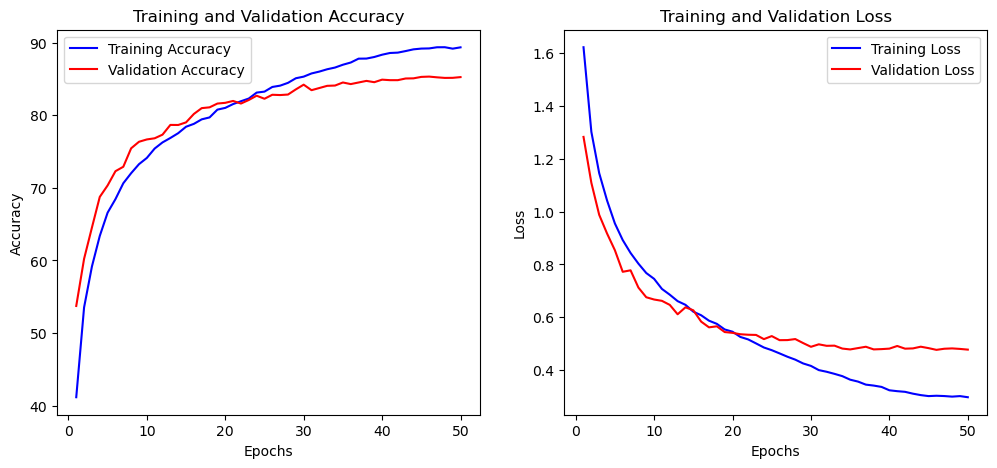

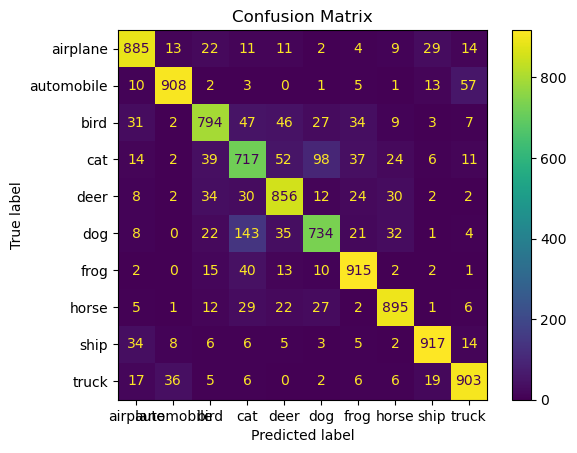

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Environment Setup
# Define device to use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Preprocessing and Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Model Setup - ResNet-18
net = models.resnet18(pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 10)  # Adjust output layer for CIFAR-10 classes
net = net.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training Loop
num_epochs = 50
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        outputs = net(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()  # Update weights
        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / len(trainloader))
    scheduler.step()  # Update learning rate

    # Validation
    net.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc.append(100 * val_correct / val_total)
    val_loss.append(val_running_loss / len(testloader))

    # Print statistics for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Acc: {train_acc[-1]:.2f}%, Val Loss: {val_running_loss / len(testloader):.4f}, Val Acc: {val_acc[-1]:.2f}%')

# Plot Training and Validation Curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix
net.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trainset.classes)
disp.plot()
plt.title('Confusion Matrix')
plt.show()